In [1]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
# Import Data
df = pd.read_csv("/Users/genoc/Desktop/HyannisHarborHawks/Trackman/Cape_Trackman_Combined_July7.csv",low_memory=False)

# Clean Trackman Data
dft = df[['Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'PitcherThrows', 'RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak', 'PitchCall', 'PlayResult', 'TaggedHitType', 'KorBB']]

#Rename the columns to be more descriptive
dft.rename(columns={'BatterTeam':'Batter Team', 'PitcherTeam':'Pitcher Team', 'PitcherThrows':'P Side', 'RelSpeed':'Velocity', 'SpinRate':'Spin Rate', 'RelHeight':'Release Height', 'RelSide':'Release Side', 'Extension':'Extension', 'InducedVertBreak':'Induced Vertical Break', 'HorzBreak':'Horizontal Break', 'PitchCall':'Pitch Call', 'PlayResult':'Play Result', 'TaggedHitType':'Hit Type'}, inplace=True)

#Add the Pitch Type and Pitch Result to the new dataframe
dft.insert(1, 'Pitch Type', df['TaggedPitchType'])
dft.insert(2, 'Pitch Result', df['PitchCall'])

#Create a new column for the difference between the Induced Vertical Break and the Horizontal Break (Absolute Value)
dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()

#Add two new columns for Pitch Location
dft.insert(10, 'Pitch Height', df['PlateLocHeight'])
dft.insert(11, 'Pitch Side', df['PlateLocSide'])

#Edit Horizontal Break to be absolute value of horizontal break
dft['Horizontal Break'] = abs(dft['Horizontal Break'])

dft['Release Side'] = abs(dft['Release Side'])

# Edit the pitcher names so the first name is first and the last name is last
dft['Pitcher'] = dft['Pitcher'].str.split(' ', expand=True)[1] + ' ' + dft['Pitcher'].str.split(' ', expand=True)[0]

# Edit the batter names so the first name is first and the last name is last
dft['Batter'] = dft['Batter'].str.split(' ', expand=True)[1] + ' ' + dft['Batter'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
dft = dft.replace(',', '', regex=True)

# Add Swings and Misses to dft
dft['Whiff'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" else 0)
dft['Swing'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" or x == "InPlay" else 0)

# Calculates total swings and total misses across all of dft
total_swings = dft['Swing'].sum()
total_misses = dft['Whiff'].sum()

# Calculates Whiff Rate for all of dft
league_average_whiff_rate = total_misses / total_swings

# Create a new dataframe with only pitches that are Sinkers
dfsi = dft[(dft['Pitch Type'] == 'Sinker')]

# Handle NA values
dfsi.fillna(dfsi.mean(), inplace=True)

#dfbr[['Velocity', 'Spin Rate', 'Release Height', 'Release Side', 'Extension', 'Horizontal Break', 'Differential Break', 'Induced Vertical Break']].corr()

dfsi['Velo Pow'] = pow(dfsi['Velocity'], 3) + pow(dfsi['Velocity'], 2)
dfsi['HorizBrk Pow'] = pow(dfsi['Horizontal Break'], 3) + pow(dfsi['Horizontal Break'], 2)
dfsi['DiffBreak^2'] = pow(dfsi['Differential Break'], 3)
dfsi['Release Height^2'] = pow(dfsi['Release Height'], 2)
dfsi['IndVert * Velo'] = dfsi['Induced Vertical Break'] * dfsi['Velocity']

# Filter to only include swings
dfsi_swing = dfsi[(dfsi['Swing'] == 1)]

C:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-2-c96931da0b30>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()
<ipython-input-2-c96931da0b30>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [3]:
dfsi[['Velo Pow', 'HorizBrk Pow', 'DiffBreak^2', 'Release Height^2', 'IndVert * Velo', 'Spin Rate', 'Release Side', 'Extension']].corr()

,Velo Pow,HorizBrk Pow,DiffBreak^2,Release Height^2,IndVert * Velo,Spin Rate,Release Side,Extension
Velo Pow,1.000000,-0.012523,-0.160463,0.229340,0.368512,0.251149,-0.166236,0.039796
HorizBrk Pow,-0.012523,1.000000,0.255871,-0.042388,-0.113166,0.083558,0.149540,-0.217980
DiffBreak^2,-0.160463,0.255871,1.000000,0.008846,-0.042270,-0.070475,0.132124,-0.221589
Release Height^2,0.229340,-0.042388,0.008846,1.000000,0.483183,-0.112920,-0.241445,-0.065166
IndVert * Velo,0.368512,-0.113166,-0.042270,0.483183,1.000000,0.079010,-0.190406,0.229378
Spin Rate,0.251149,0.083558,-0.070475,-0.112920,0.079010,1.000000,0.070617,-0.212489
Release Side,-0.166236,0.149540,0.132124,-0.241445,-0.190406,0.070617,1.000000,-0.048873
Extension,0.039796,-0.217980,-0.221589,-0.065166,0.229378,-0.212489,-0.048873,1.000000


In [4]:
# Linear regression Model

X = dfsi_swing[['Velo Pow', 'HorizBrk Pow', 'DiffBreak^2', 'Release Height^2', 'IndVert * Velo', 'Spin Rate', 'Release Side', 'Extension']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfsi_swing['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression object
linear_model = LinearRegression()

# Train the linear regression model using the training data
linear_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the linear regression model
y_linear_pred = linear_model.predict(X_test_scaled)

# Evaluate the linear regression model's performance
linear_mse = mean_squared_error(y_test, y_linear_pred)
linear_r2 = r2_score(y_test, y_linear_pred)

print("Linear Regression Mean Squared Error:", linear_mse)
print("Linear Regression R-squared score:", linear_r2)

Linear Regression Mean Squared Error: 0.22072847385360395
Linear Regression R-squared score: -0.042547880969254104


In [5]:
# Get the feature coefficients from the model
feature_importances = linear_model.coef_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)


                  importance
Extension           0.021923
Spin Rate           0.020822
DiffBreak^2         0.018738
Release Height^2    0.015389
HorizBrk Pow        0.011190
IndVert * Velo     -0.001894
Velo Pow           -0.009260
Release Side       -0.032644


In [6]:
# Random Forest Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor object
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model using the training data
random_forest_model.fit(X_train, y_train)

# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = random_forest_model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.23537926549254254
Random Forest R-squared score: -0.11174670933531239


In [7]:
# Get feature importances from the model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                  importance
Velo Pow            0.144792
IndVert * Velo      0.138034
HorizBrk Pow        0.137658
DiffBreak^2         0.121542
Spin Rate           0.118350
Extension           0.116031
Release Side        0.115673
Release Height^2    0.107920


In [8]:
# XG Boost Model

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model's performance
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared score:", xgb_r2)

XGBoost Mean Squared Error: 0.2576132331152455
XGBoost R-squared score: -0.2167625028389717


In [9]:
# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                  importance
Release Side        0.156409
Extension           0.145559
HorizBrk Pow        0.134581
IndVert * Velo      0.132090
Release Height^2    0.119950
Spin Rate           0.114679
DiffBreak^2         0.113340
Velo Pow            0.083392


In [10]:
# SVR Model 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Support Vector Regression model
svr_model = SVR(kernel='linear')

# Train the model using the training data
svr_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the SVR model
y_pred = svr_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

Mean Squared Error: 0.2534904025822333
R-squared score: -0.1972894907678695


In [11]:
# Neural Networks Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Single output neuron for the Stuff+ score prediction

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model using the training data
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predict Stuff+ scores for the test set using the Neural Network model
y_pred = nn_model.predict(X_test_scaled).flatten()

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

4/4 [==============================] - 0s 3ms/step
Mean Squared Error: 0.276301166765325
R-squared score: -0.3050296180255081


In [12]:
# Ensemble model

# Make predictions using all the models
linear_pred = linear_model.predict(X_test_scaled)
rf_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)
keras_nn_pred = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging
ensemble_predictions = (linear_pred + rf_pred + xgb_pred + svr_pred + keras_nn_pred) / 5.0

4/4 [==============================] - 0s 4ms/step


In [13]:
# Get feature importances from the RandomForestRegressor and XGBRegressor models
rf_feature_importances = random_forest_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_

# Calculate average feature importances across the two models
average_feature_importances = (rf_feature_importances + xgb_feature_importances) / 2.0

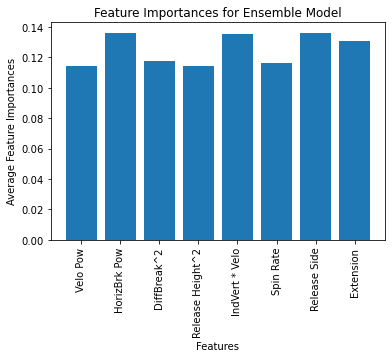

In [14]:
features_list = ['Velo Pow', 'HorizBrk Pow', 'DiffBreak^2', 'Release Height^2', 'IndVert * Velo', 'Spin Rate', 'Release Side', 'Extension']

plt.bar(features_list, average_feature_importances)
plt.xlabel('Features')
plt.ylabel('Average Feature Importances')
plt.title('Feature Importances for Ensemble Model')
plt.xticks(rotation=90)
plt.show()

In [15]:
X = dfsi[['Velo Pow', 'HorizBrk Pow', 'DiffBreak^2', 'Release Height^2', 'IndVert * Velo', 'Spin Rate', 'Release Side', 'Extension']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfsi['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Make predictions on the training set using all the models
linear_pred_train = linear_model.predict(X_train_scaled)
rf_pred_train = random_forest_model.predict(X_train_scaled)
xgb_pred_train = xgb_model.predict(X_train_scaled)
svr_pred_train = svr_model.predict(X_train_scaled)
keras_nn_pred_train = nn_model.predict(X_train_scaled).flatten()

53/53 [==============================] - 0s 2ms/step


In [17]:
# Make predictions on the test set using all the models
linear_pred_test = linear_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
svr_pred_test = svr_model.predict(X_test_scaled)
keras_nn_pred_test = nn_model.predict(X_test_scaled).flatten()

14/14 [==============================] - 0s 2ms/step


In [18]:
# Combine predictions using averaging for the training set
ensemble_predictions_train = (linear_pred_train + rf_pred_train + xgb_pred_train + svr_pred_train + keras_nn_pred_train) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the training set
ensemble_df_train = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_train}, index=X_train.index)

In [19]:
# Combine predictions using averaging for the test set
ensemble_predictions_test = (linear_pred_test + rf_pred_test + xgb_pred_test + svr_pred_test + keras_nn_pred_test) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the test set
ensemble_df_test = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_test}, index=X_test.index)

In [20]:
# Concatenate the training and test set DataFrames
ensemble_df = pd.concat([ensemble_df_train, ensemble_df_test])

In [22]:
# Calculate the 'Stuff+' values
dfsi['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100

<ipython-input-22-79d6918a8218>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsi['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100


In [24]:
dfsi = dfsi.round(2)
dfsi['Stuff+'].describe()

count    2090.000000
mean      100.000244
std        32.606801
min        16.380000
25%        73.730000
50%        92.935000
75%       118.920000
max       222.810000
Name: Stuff+, dtype: float64

In [25]:
# Sort the DataFrame by 'Stuff+' values in descending order
dfsi_sorted = dfsi.sort_values(by='Stuff+', ascending=False)

# Reset the index of the sorted DataFrame
dfsi_sorted.reset_index(drop=True, inplace=True)

dfsi_sorted.head(20)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,KorBB,Differential Break,Whiff,Swing,Velo Pow,HorizBrk Pow,DiffBreak^2,Release Height^2,IndVert * Velo,Stuff+
0,Brett Wichrowski,Sinker,StrikeCalled,WAR_GAT,Nolan Schubart,CHA_ANG,Right,82.39,2433.48,5.56,...,Strikeout,11.14,0,0,565984.10,1121.42,1384.13,30.94,88.81,222.81
1,Jacob Exum,Sinker,StrikeCalled,BOU_BRA,Ben Williamson,HYA_HAR,Right,84.51,2280.31,3.83,...,Undefined,26.55,0,0,610802.97,13586.84,18711.95,14.67,-254.83,215.38
2,Cam Leiter,Sinker,BallCalled,ORL_FIR,Kaelen Culpepper,HAR_MAR,Undefined,83.16,2595.84,6.04,...,Undefined,4.18,0,0,582037.22,378.17,72.97,36.43,-227.39,211.88
3,Lucas Mahlstedt,Sinker,StrikeCalled,WAR_GAT,Kalae Harrison,COT_KET,Right,73.73,2727.03,3.21,...,Undefined,28.48,0,0,406168.15,4795.46,23103.13,10.28,880.62,211.31
4,Aidan Moza,Sinker,StrikeSwinging,HAR_MAR,Jake Hyde,ORL_FIR,Right,94.21,1971.02,6.00,...,Undefined,4.86,1,1,844906.19,8943.76,114.64,36.00,1466.92,208.44
5,Aidan Moza,Sinker,StrikeCalled,HAR_MAR,Jake Hyde,ORL_FIR,Right,92.80,1947.44,6.01,...,Undefined,2.19,0,0,807907.69,8619.93,10.50,36.10,1669.21,207.95
6,Smith Pinson,Sinker,StrikeSwinging,YAR_RED,Joshua Kuroda-Grauer,BOU_BRA,Right,80.60,1913.55,5.93,...,Strikeout,7.08,1,1,530191.60,3081.84,355.46,35.17,575.75,206.88
7,Jake Faherty,Sinker,StrikeCalled,WAR_GAT,Derek Bender,BOU_BRA,Right,85.52,2715.86,5.86,...,Undefined,13.62,0,0,632834.93,1295.23,2527.87,34.31,260.43,204.68
8,John Modugno,Sinker,BallCalled,BRE_WHI,Kyson Donahue,CHA_ANG,Right,85.67,2606.20,6.39,...,Undefined,9.74,0,0,636084.95,40.63,923.97,40.88,565.86,201.44
9,Aidan Moza,Sinker,BallCalled,HAR_MAR,Jake Hyde,ORL_FIR,Right,94.22,2063.94,5.95,...,Undefined,3.56,0,0,845409.02,8810.55,45.02,35.45,1579.99,200.53


In [26]:
average_si_Stuff = dfsi[dfsi['Pitch Type'] == 'Sinker'].groupby('Pitcher')['Stuff+'].mean()
average_si_Stuff = average_si_Stuff.round(2)

# Sort the Series in descending order based on the average Stuff+ values
average_si_Stuff_sorted = average_si_Stuff.sort_values(ascending=False)

average_si_Stuff_sorted

Pitcher
Cam Leiter            211.88
Jake Faherty          204.68
Alexander Hughes      192.22
Matt Duffy            190.08
Aidan Moza            178.04
                       ...  
Adan Moza              58.88
Mark Manfredi          55.34
Parker Coil            51.65
Christopher Kahler     49.09
Andrew Shaffner        36.40
Name: Stuff+, Length: 121, dtype: float64